In [299]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from scipy.stats import kurtosis
from scipy.stats import skew
import scipy.stats as ss
from sklearn.metrics import *

In [300]:
# import merged dataset for Birds in four cities across different times
data = pd.read_csv('final_merge.csv', index_col=0)

In [301]:
# create log features for closest_highway, closest primary, closest residential, closest secondary and closest scooter
data['log_highway'] = np.log(data['closest_highway'])
data['log_scooter'] = np.log(data['closest_scooter'])
data['log_primary'] = np.log(data['closest_primary'])
data['log_residential'] = np.log(data['closest_residential'])
data['log_secondary'] = np.log(data['closest_secondary'])

# Plotting Distributions

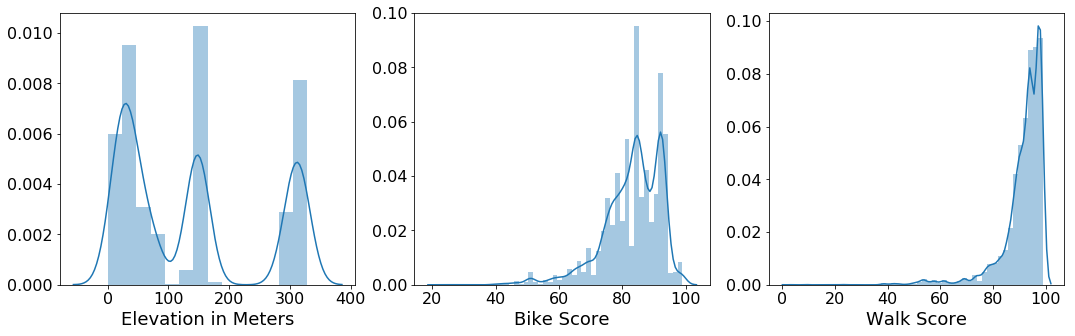

In [302]:
# Plot distributions
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 5))

sns.distplot(data['elevation'], ax=ax0); ax0.set_xlabel('Elevation in Meters', fontsize=18)
sns.distplot(data['bike_score'], ax=ax1); ax1.set_xlabel('Bike Score', fontsize=18)
sns.distplot(data['walk_score'], ax=ax2); ax2.set_xlabel('Walk Score', fontsize=18)

ax0.tick_params(labelsize=16); ax1.tick_params(labelsize=16); ax2.tick_params(labelsize=16);

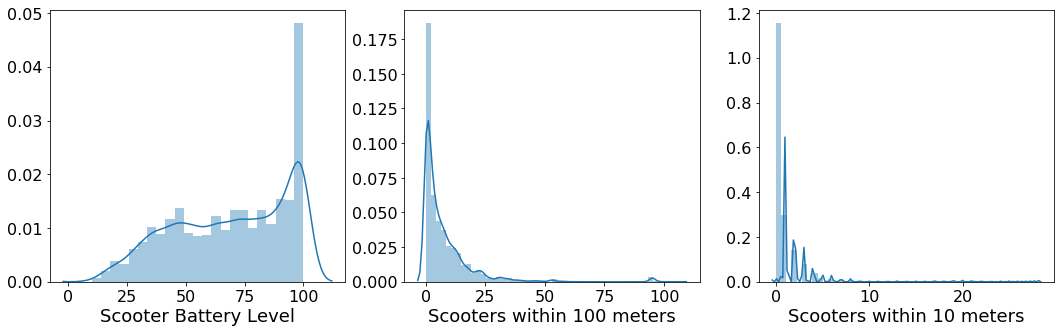

In [303]:
fig, (ax3, ax4, ax5) = plt.subplots(1, 3, figsize=(18, 5))

sns.distplot(data['battery_level'], ax=ax3); ax3.set_xlabel('Scooter Battery Level', fontsize=18);
sns.distplot(data['hundred_meter'], ax=ax4); ax4.set_xlabel('Scooters within 100 meters', fontsize=18)
sns.distplot(data['ten_meter'], ax=ax5); ax5.set_xlabel('Scooters within 10 meters', fontsize=18)

ax3.tick_params(labelsize=16); ax4.tick_params(labelsize=16); ax5.tick_params(labelsize=16); 

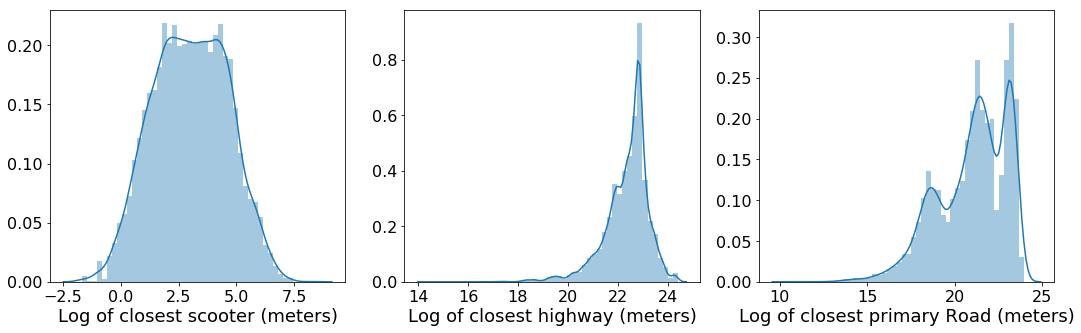

In [304]:
fig, (ax6, ax7, ax8) = plt.subplots(1, 3, figsize=(18, 5))

sns.distplot(data['log_scooter'], ax=ax6); ax6.set_xlabel('Log of closest scooter (meters)', fontsize=18)
sns.distplot(data['log_highway'], ax=ax7); ax7.set_xlabel('Log of closest highway (meters)', fontsize=18)
sns.distplot(data['log_primary'], ax=ax8); ax8.set_xlabel('Log of closest primary Road (meters)', fontsize=18)


ax6.tick_params(labelsize=16); ax7.tick_params(labelsize=16); ax8.tick_params(labelsize=16);

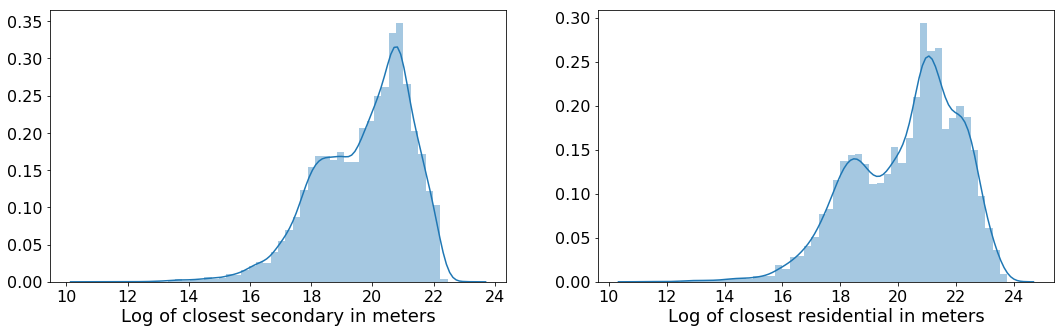

In [305]:
fig, (ax9, ax10) = plt.subplots(1, 2, figsize=(18, 5))

sns.distplot(data['log_residential'], ax=ax9); ax9.set_xlabel('Log of closest secondary in meters', fontsize=18)
sns.distplot(data['log_secondary'], ax=ax10); ax10.set_xlabel('Log of closest residential in meters', fontsize=18)


ax9.tick_params(labelsize=16); ax10.tick_params(labelsize=16); 

# Statistical Analysis

In [306]:
data.groupby('nest_dummy')['bike_score'].mean()

nest_dummy
0    83.168605
1    82.786431
Name: bike_score, dtype: float64

In [307]:
# create stratified bike scores by nest_dummy
nest = data['bike_score'][data['nest_dummy'] == 1]
no_nest = data['bike_score'][data['nest_dummy'] == 0]

In [308]:
# write t_test function
def t_test(a, b, alpha, alternative='two-sided'):
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b, equal_var=False)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   

In [309]:
test = t_test(nest, no_nest, 0.05)
test 

DegFreedom    3325.950479
Difference      -0.382174
Statistic       -1.755682
PValue           0.079235
Low95CI         -0.808972
High95CI         0.044623
dtype: float64

The PValue is greater than the 5% significance level and the 95% Confidence interval straddles 0 so we cannot reject the null hypothesis. This means there is a high chance that the difference in means is from random variation alone.

In [310]:
data.groupby('nest_dummy')['walk_score'].mean()

nest_dummy
0    91.206909
1    92.601051
Name: walk_score, dtype: float64

In [311]:
# create stratified walk scores by nest_dummy
nest = data['walk_score'][data['nest_dummy'] == 1]
no_nest = data['walk_score'][data['nest_dummy'] == 0]

In [312]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom    4.257916e+03
Difference    1.394142e+00
Statistic     8.165327e+00
PValue        4.182608e-16
Low95CI       1.059404e+00
High95CI      1.728880e+00
dtype: float64

The PValue is less than the 5% signficance level and the 95% confidence interval does not straddle 0 so we reject the null hypothesis. There is a significant difference in means of walk score by nest classification.

In [313]:
data.groupby('nest_dummy')['battery_level'].mean()

nest_dummy
0    62.900364
1    94.888199
Name: battery_level, dtype: float64

In [314]:
# create stratified battery level by nest_dummy
nest = data['battery_level'][data['nest_dummy'] == 1]
no_nest = data['battery_level'][data['nest_dummy'] == 0]

In [315]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom    7941.339627
Difference      31.987835
Statistic       98.086971
PValue           0.000000
Low95CI         31.348559
High95CI        32.627110
dtype: float64

The PValue is less than the 5% signficance level and the 95% confidence interval does not straddle 0 so we reject the null hypothesis. There is a significant difference in means of battery levels by nest classification.

In [316]:
data.groupby('nest_dummy')['log_scooter'].mean()

nest_dummy
0    3.281436
1    1.891617
Name: log_scooter, dtype: float64

In [317]:
# create stratified log of closest scooter in meters by nest_dummy
nest = data['log_scooter'][data['nest_dummy'] == 1]
no_nest = data['log_scooter'][data['nest_dummy'] == 0]

In [318]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom     3.420579e+03
Difference    -1.389818e+00
Statistic     -3.966912e+01
PValue        1.856563e-283
Low95CI       -1.458511e+00
High95CI      -1.321126e+00
dtype: float64

The PValue is less than the 5% signficance level and the 95% confidence interval does not straddle 0 so we reject the null hypothesis. There is a significant difference in means of log of closest scooter in meters by nest classification.

In [319]:
data.groupby('nest_dummy')['ten_meter'].mean()

nest_dummy
0    0.764305
1    1.751075
Name: ten_meter, dtype: float64

In [320]:
# create stratified scooters within 10 meters by nest_dummy
nest = data['ten_meter'][data['nest_dummy'] == 1]
no_nest = data['ten_meter'][data['nest_dummy'] == 0]

In [321]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom    3.399688e+03
Difference    9.867700e-01
Statistic     1.715737e+01
PValue        2.391500e-63
Low95CI       8.740067e-01
High95CI      1.099533e+00
dtype: float64

The PValue is less than the 5% signficance level and the 95% confidence interval does not straddle 0 so we reject the null hypothesis. There is a significant difference in means of scooter count within 10 meters by nest classification

In [322]:
data.groupby('nest_dummy')['elevation'].mean()

nest_dummy
0    128.608504
1    166.415091
Name: elevation, dtype: float64

In [323]:
# create stratified elevation in meters by nest_dummy
nest = data['elevation'][data['nest_dummy'] == 1]
no_nest = data['elevation'][data['nest_dummy'] == 0]

In [324]:
test = t_test(nest, no_nest, 0.05)
test

DegFreedom    2.933097e+03
Difference    3.780659e+01
Statistic     1.262410e+01
PValue        1.290138e-35
Low95CI       3.193448e+01
High95CI      4.367870e+01
dtype: float64

The PValue is less than the 5% signficance level and the 95% confidence interval does not straddle 0 so we reject the null hypothesis. There is a significant difference in means of scooter elevation in meters by nest classification

In [343]:
#explore correlations between features and to the Nest Dummy
features = ['log_scooter', 'battery_level', 'fifty_meter', 'ten_meter', 'hundred_meter',
              'twentyfive_meter', 'low_bat_proximity', 'highest_bat_proximity',
                'elevation', 'log_highway', 'log_primary', 'log_secondary', 'log_residential', 'nest_dummy']
corr = data[features]

corr.corr()

,log_scooter,battery_level,fifty_meter,ten_meter,hundred_meter,twentyfive_meter,low_bat_proximity,highest_bat_proximity,elevation,log_highway,log_primary,log_secondary,log_residential,nest_dummy
log_scooter,1.000000,-0.296934,-0.377434,-0.499610,-0.411676,-0.385697,-0.351223,-0.427653,-0.201449,0.013997,0.020386,0.185750,-0.019925,-0.343508
battery_level,-0.296934,1.000000,0.167968,0.214280,0.164773,0.180939,-0.043747,0.275591,0.092704,0.004142,0.033564,-0.060601,-0.020863,0.521242
fifty_meter,-0.377434,0.167968,1.000000,0.752496,0.893791,0.942607,0.178890,0.365034,0.198329,0.054184,0.022245,-0.194940,0.060637,0.045865
ten_meter,-0.499610,0.214280,0.752496,1.000000,0.623593,0.860233,0.317410,0.574256,0.110007,0.021526,0.024458,-0.114123,-0.027767,0.156944
hundred_meter,-0.411676,0.164773,0.893791,0.623593,1.000000,0.795458,0.181779,0.293698,0.242223,0.079619,-0.048389,-0.227512,0.112154,0.066357
twentyfive_meter,-0.385697,0.180939,0.942607,0.860233,0.795458,1.000000,0.184074,0.428209,0.161819,0.042836,0.039834,-0.165449,0.018701,0.066784
low_bat_proximity,-0.351223,-0.043747,0.178890,0.317410,0.181779,0.184074,1.000000,0.044389,0.028604,-0.020478,-0.068153,-0.050939,0.031900,-0.053546
highest_bat_proximity,-0.427653,0.275591,0.365034,0.574256,0.293698,0.428209,0.044389,1.000000,0.090827,-0.009260,0.045555,-0.095724,-0.043251,0.351218
elevation,-0.201449,0.092704,0.198329,0.110007,0.242223,0.161819,0.028604,0.090827,1.000000,0.065955,0.491302,-0.398456,0.179016,0.131521
log_highway,0.013997,0.004142,0.054184,0.021526,0.079619,0.042836,-0.020478,-0.009260,0.065955,1.000000,-0.178750,0.188104,-0.186246,-0.007123


# Additional Visualizations

Text(0.5,1,'Log of Closest Scooter in Meters vs Walk Score \n with Nest Classification by color')

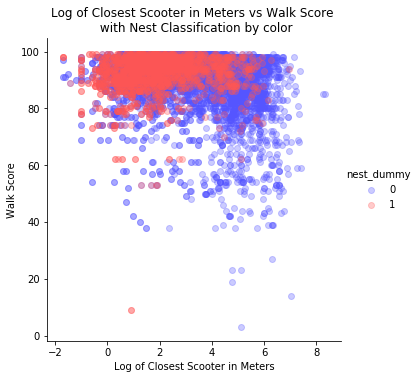

In [325]:
sns.lmplot(x = 'log_scooter', y = 'walk_score', 
           data = data, 
           hue = "nest_dummy", 
           palette="seismic", 
           scatter_kws={'alpha':0.3},
           fit_reg = False)
plt.xlabel('Log of Closest Scooter in Meters')
plt.ylabel('Walk Score')
plt.title('Log of Closest Scooter in Meters vs Walk Score \n with Nest Classification by color')

Text(0.5,1,'Log of Closest Scooter in Meters vs Battery Level \n with Nest Classification by color')

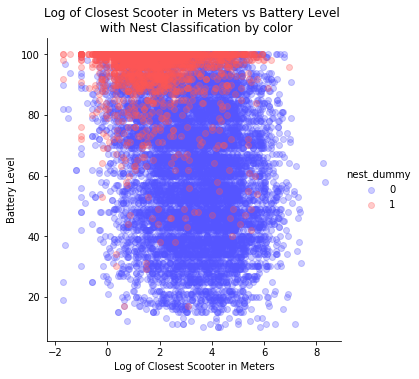

In [326]:
sns.lmplot(x = 'log_scooter', y = 'battery_level', 
           data = data, 
           hue = "nest_dummy", 
           palette="seismic", 
           scatter_kws={'alpha':0.3},
           fit_reg = False)
plt.xlabel('Log of Closest Scooter in Meters')
plt.ylabel('Battery Level')
plt.title('Log of Closest Scooter in Meters vs Battery Level \n with Nest Classification by color')

Text(0.5,1,'Log of Closest Highway in Meters vs \n Log of Closest Residential road in Meters \n with Nest Classification by color')

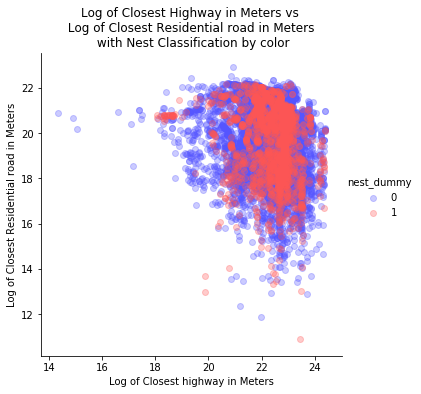

In [327]:
sns.lmplot(x = 'log_highway', y = 'log_residential', 
           data = data, 
           hue = "nest_dummy", 
           palette="seismic", 
           scatter_kws={'alpha':0.3},
           fit_reg = False)
plt.xlabel('Log of Closest highway in Meters')
plt.ylabel('Log of Closest Residential road in Meters')
plt.title('Log of Closest Highway in Meters vs \n Log of Closest Residential road in Meters \n with Nest Classification by color')

# Model Development

In [345]:
# Use the relevant features

features = ['log_scooter', 'battery_level', 'fifty_meter', 'ten_meter', 'hundred_meter', 'walk_score',
              'twentyfive_meter', 'low_bat_proximity', 'highest_bat_proximity',
                'elevation', 'log_highway', 'log_primary', 'log_secondary', 'log_residential']

X = data[features]

y = data['nest_dummy']

#split into training set and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=0)

In [346]:
#create test metrics and results ouput function

def test_results(model, Xtest, ytest):
    
    y_pred = model.predict(Xtest)
    y_pred_proba = model.predict_proba(Xtest)[:,1]

    #Confusion matrix
    CM = confusion_matrix(ytest, y_pred)
    print ("\n\nConfusion matrix:\n", CM)    

    #True Positive, True Negative, False Positive, False Negative from Confusion Matrix
    tn, fp, fn, tp = CM.ravel()
    print ("\nTP, TN, FP, FN:", tp, ",", tn, ",", fp, ",", fn)


    #Accuracy rate
    AR = accuracy_score(ytest, y_pred)
    print ("\nAccuracy rate:", np.round(AR, 3))

    #Error rate
    ER = 1.0 - AR
    print ("\nError rate:", np.round(ER, 3))

    #Precision: True Positive / (True Positive + False Positive)
    P = precision_score(ytest, y_pred)
    print ("\nPrecision:", np.round(P, 3))

    #Recall:true Positive / (Trupe Positive + False Negative)
    R = recall_score(ytest, y_pred)
    print ("\nRecall:", np.round(R, 3))

    #F1 Score
    F1 = f1_score(ytest, y_pred)
    print ("\nF1 score:", np.round(F1, 3))


    # ROC Curve and AUC Analysis
    LW = 1.5 # line width for plots
    LL = "lower right" # legend location
    LC = 'darkgreen' # Line Color

    # False Positive Rate, True Posisive Rate, probability thresholds
    fpr, tpr, th = roc_curve(ytest, y_pred_proba) 
    AUC = auc(fpr, tpr)
    #print ("\nTP rates:", np.round(tpr, 2))
    #print ("\nFP rates:", np.round(fpr, 2))
    #print ("\nProbability thresholds:", np.round(th, 2))


    plt.figure()
    plt.title('Receiver Operating Characteristic curve example')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FALSE Positive Rate')
    plt.ylabel('TRUE Positive Rate')
    plt.plot(fpr, tpr, color=LC,lw=LW, label='ROC curve (area = %0.2f)' % AUC)
    plt.plot([0, 1], [0, 1], color='navy', lw=LW, linestyle='--') 
    plt.legend(loc=LL)
    plt.show()

    print ("\nAUC score (using auc function):", np.round(AUC, 3))
    print ("\nAUC score (using roc_auc_score function):", np.round(roc_auc_score(ytest, y_pred_proba), 3), "\n")

# XGB Classifier Model

In [347]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
    'eval_metric': ['auc'],
    'max_depth': [2, 4, 6, 8, 10],
    'n_estimators': [100, 500, 750, 1000]
}



# Create a based model
xgb = XGBClassifier()


# Instantiate the grid search model
xgb_grid_search = RandomizedSearchCV(estimator = xgb, param_distributions= param_grid, 
                         cv = 5, n_jobs = -1)

# fit the model
xgb_grid_search.fit(Xtrain, ytrain)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1], 'eval_metric': ['auc'], 'max_depth': [2, 4, 6, 8, 10], 'n_estimators': [100, 500, 750, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [348]:
#Best estimator and CV score
print('Best Accuracy score ', xgb_grid_search.best_score_)
print(xgb_grid_search.best_estimator_)

Best Accuracy score  0.9085152250067368
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=0, learning_rate=0.4,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=750, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)




Confusion matrix:
 [[2419  110]
 [ 155  498]]

TP, TN, FP, FN: 498 , 2419 , 110 , 155

Accuracy rate: 0.917

Error rate: 0.083

Precision: 0.819

Recall: 0.763

F1 score: 0.79


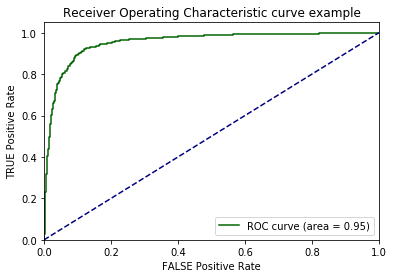


AUC score (using auc function): 0.954

AUC score (using roc_auc_score function): 0.954 



In [349]:
test_results(xgb_grid_search.best_estimator_, Xtest, ytest)

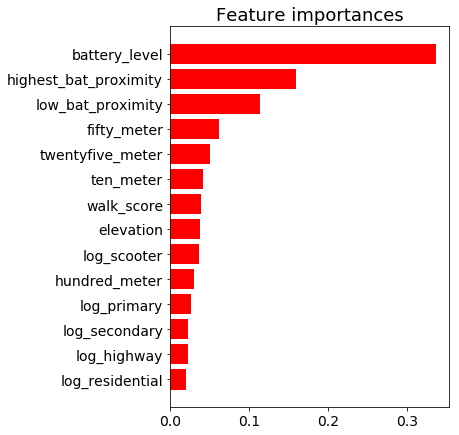

In [350]:
features = X.columns
feature_importance = xgb_grid_search.best_estimator_.feature_importances_
indices = np.argsort(feature_importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], feature_importance[indices],
       color="r",  align="center")
plt.tick_params(labelsize=14)

# Random Forest Classifier Model

In [351]:
# Number of trees in random forest
n_estimators = [300, 400, 500, 600, 700]
# Number of features to consider at every split
max_features = [2, 3, 4]
# Maximum number of levels in tree
max_depth = [20, 22, 24]
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
              'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}


#Random Search Training for hyperparamters
rf = RandomForestClassifier()

rfc_grid_search = RandomizedSearchCV(estimator = rf, param_distributions= random_grid, 
                                 cv = 5, n_jobs = -1)

rfc_grid_search.fit(Xtrain, ytrain)

/Users/perryjohnson/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/perryjohnson/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/perryjohnson/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/perryjohnson/anaconda3/lib/python3.7/site-packages/skl

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [300, 400, 500, 600, 700], 'max_features': [2, 3, 4], 'max_depth': [20, 22, 24], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [2, 3, 4], 'bootstrap': [False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [352]:
#Best estimator and CV score
print('Best Accuracy score ', rfc_grid_search.best_score_)
print(rfc_grid_search.best_estimator_)

Best Accuracy score  0.9067636755591485
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=20, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)




Confusion matrix:
 [[2412  117]
 [ 170  483]]

TP, TN, FP, FN: 483 , 2412 , 117 , 170

Accuracy rate: 0.91

Error rate: 0.09

Precision: 0.805

Recall: 0.74

F1 score: 0.771


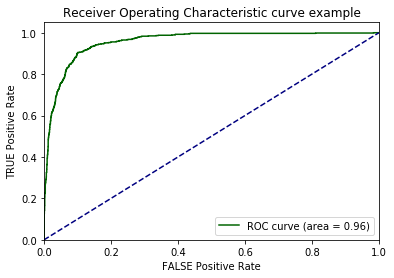


AUC score (using auc function): 0.957

AUC score (using roc_auc_score function): 0.957 



In [353]:
test_results(rfc_grid_search.best_estimator_, Xtest, ytest)

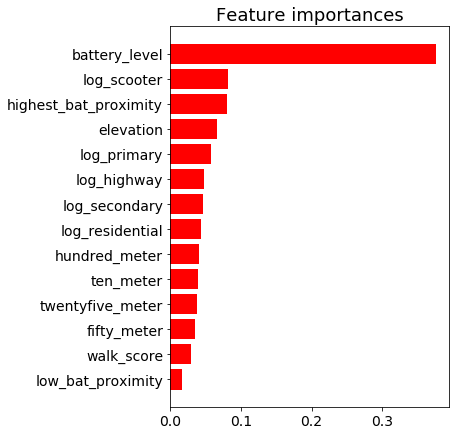

In [354]:
features = X.columns
feature_importance = rfc_grid_search.best_estimator_.feature_importances_
indices = np.argsort(feature_importance)
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], feature_importance[indices],
       color="r",  align="center")
plt.tick_params(labelsize=14)